In [3]:
%matplotlib inline
import astropy.io.fits as pyfits
import PythonPhot as pp
import numpy as np

# read in some sample data from SDSS
gimage,rimage = \
    pyfits.getdata('Pal5-g-SDSS.fits'),pyfits.getdata('Pal5-r-SDSS.fits')

# convert units back into counts for poisson statistics
ggain = 1/pyfits.getval('Pal5-g-SDSS.fits','NMGY')
rgain = 1/pyfits.getval('Pal5-r-SDSS.fits','NMGY')
gimage *= ggain
rimage *= rgain

Input Image Size is 2048 by 1489
RELATIVE ERROR computed from FWHM 0.80026299048
Beginning convolution of image
Finished convolution of image
1708 local maxima located above threshold
     STAR      X      Y     FLUX     SHARP    ROUND
(' No. of sources rejected by SHARPNESS criteria', 4)
(' No. of sources rejected by ROUNDNESS criteria', 14)
(' No. of sources rejected by CENTROID  criteria', 3)
Input Image Size is 2048 by 1489
RELATIVE ERROR computed from FWHM 0.80026299048
Beginning convolution of image
Finished convolution of image
2089 local maxima located above threshold
     STAR      X      Y     FLUX     SHARP    ROUND
(' No. of sources rejected by SHARPNESS criteria', 12)
(' No. of sources rejected by ROUNDNESS criteria', 30)
(' No. of sources rejected by CENTROID  criteria', 4)


(450, 1250)

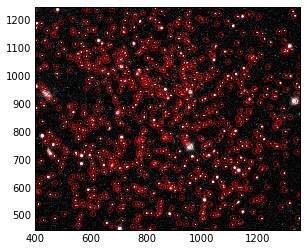

In [6]:
# now let's get started with the find.py algorithm

# first the sky background - let's just call the readnoise 0
rskymod, rskysig, rskyskw = pp.mmm.mmm(rimage,readnoise=0,minsky=200)
gskymod, gskysig, gskyskw = pp.mmm.mmm(rimage,readnoise=0,minsky=200)
# This algorithm is not the best, helps to tune hmin a bit
rhmin = rskysig*5
ghmin = gskysig*5
# take a stab at the image FWHM
fwhm = 5

gxstar,gystar,flux,sharp,round = \
    pp.find.find(gimage,ghmin,fwhm,[-1.0,1.0],[0.2,1.0])
rxstar,rystar,flux,sharp,round = \
    pp.find.find(rimage,rhmin,fwhm,[-1.0,1.0],[0.2,1.0])  

# Now let's see how we did
import pylab as plt
plt.ion()
plt.imshow(gimage,vmin=0,vmax=10*gskysig,cmap='Greys_r')
plt.plot(gxstar,gystar,'o',ms=5,mfc='none',lw=2,mec='r')
plt.xlim([400,1350]); plt.ylim([450,1250])
# not bad!

In [ ]:
# let's do some aperture photometry and 
# see how the color mag diagrams look

# first, draw a box around just the cluster stars
ipal_g = ((gxstar > 400) & (gxstar < 1350) &
          (gystar > 450) & (gystar < 1250))
ipal_r = ((rxstar > 400) & (rxstar < 1350) &
          (rystar > 450) & (rystar < 1250))
print('detected %i cluster stars'%len(np.where(ipal_g == True)[0]))

# coords are close in both images, but not exactly
# let's centroid them
gxstar,gystar = pp.cntrd.cntrd(gimage,gxstar,gystar,fwhm,verbose=False)
rxstar,rystar = pp.cntrd.cntrd(rimage,rxstar,rystar,fwhm,verbose=False)

gmag,gmagerr,gflux,gfluxerr,gsky,gskyerr,badflag,outstr = \
    pp.aper.aper(gimage/ggain,gxstar[ipal_g],gystar[ipal_g],phpadu=ggain,apr=5,zeropoint=25.11,
    skyrad=[3*fwhm,5*fwhm],badpix=[-12000,60000],exact=True,setskyval=0)
rmag,rmagerr,rflux,rfluxerr,rsky,rskyerr,badflag,outstr = \
    pp.aper.aper(rimage/rgain,rxstar[ipal_r],rystar[ipal_r],phpadu=rgain,apr=5,zeropoint=24.80,
    skyrad=[3*fwhm,5*fwhm],badpix=[-12000,60000],exact=True,setskyval=0)

# match up g and r coords
gmag_pal,rmag_pal = np.array([]),np.array([])
for gx,gy,i in zip(gxstar[ipal_g],gystar[ipal_g],range(len(gmag))):
    sep = np.sqrt((gx-rxstar[ipal_r])**2.+ (gy-rystar[ipal_r])**2.)
    imatch = np.where((sep == min(sep)))
    if len(imatch[0]):
        gmag_pal,rmag_pal = np.append(gmag_pal,gmag[i]),\
            np.append(rmag_pal,rmag[imatch][0])
    
plt.plot(gmag_pal-rmag_pal,rmag_pal,'.',color='k')
plt.ylim([25,17])
plt.xlim([0.3,1.5])
plt.ylabel('$g$')
plt.xlabel('$g-r$')
# Not the prettiest color mag diagram - I really should 
# be matching up WCS coordinates instead of pixel coords
# as these images are not quite WCS-aligned.
# But, it works!

In [13]:
# Let's just look at the brightest stars
# for the next steps, pkfit is a little slow
ibright = np.argsort(gmag)[0:50]
gxstar,gystar,gflux = gxstar[ipal_g][ibright],gystar[ipal_g][ibright],gflux[ibright]

IndexError: index 267 is out of bounds for axis 0 with size 50